<a href="https://colab.research.google.com/github/MarkStephens060482/Beijing-Air-Quality/blob/main/Assignment_2_PCR_model_book_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Foundations of Computer Science - Python B
### Mark Stephens - a1847018

# Beijing Multi-Site Air Quality dataset

The data set considers hourly observations of 6 main air pollutants and 6 relevant meteorological variables at multiple sites in Beijing over a 5 year period. The data is recorded by 12 nationally-controlled air-quality monitoring sites.

<center>
<h2> The Data </h2>
    
The data used in this project was sourced from Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data. The dataset contains daily weather information of temperature, pressure, dewpoint, precipitation, wind direction and wind speed. The data set has undergone preprocessing of missing value imputation, removeal of outliers and some variable transformation.

***
## Loading the cleaned data set
The preprocessed data set is loaded.

In [ ]:
# importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob

#_________The data files are to be loaded into current working directory___________
# Get the current working directory
cwd = os.getcwd()

file = cwd + '\clean_beijing_df.csv'

with open(file,encoding="utf-8") as dataFile:
        beijing_df = pd.read_csv(dataFile,index_col=0)
# view the dataframe
beijing_df.head()


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,station,weekend
0,2013,3,1,0,4.0,4.0,4.0,7.000000,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Aotizhongxin,no
1,2013,3,1,0,3.0,6.0,13.0,7.000000,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,E,Changping,no
2,2013,3,1,0,4.0,4.0,3.0,3.997836,200.0,82.0,-2.3,1020.8,-19.7,0.0,0.5,E,Dingling,no
3,2013,3,1,0,9.0,9.0,3.0,17.000000,300.0,89.0,-0.5,1024.5,-21.4,0.0,5.7,NNW,Dongsi,no
4,2013,3,1,0,4.0,4.0,14.0,20.000000,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Guanyuan,no


***
## Regression models and preprocessing.
### Principal Component Linear Regression.
Further preprocessing sets are to be done seperately to training and testing sets and are as follows:
1. drop unimportant features based on exploratory data analysis.
2. one hot encode selected categorical variables.
3. standardise selected feature variables.
4. produce principal components of feature variables

The Linear regression model is then defined.        

#### Feature selection 
Based on the findings from the correlstion analysis and principal component analysis, the following are the features to be excluded from the model:
1. **year**
2. **month**
3. **day**
4. **PM10**
5. **RAIN**
6. **station**
7. **wd**

They will be dropped from the dataset and this step will be built in a column transformer and will be a step in a pipeline.

#### Transforming nominal variables
The remaining nominal variables, **weekend** is to be One Hot encoded. This step will be built into the column transformer as a preprocessing step in the model pipeline. 

#### Standardisation
Standardising all the predictor variables to have a mean of zero and a standard deviation of 1. This is necessary before finding principal components.

#### Principal Components
Principal components of the predictor variables are determined. The number of components is determined by tuning the n_component parameter.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 

# list of unwanted features for linear regression model
drop_features = ['year','month','day','PM10', 'RAIN','station','wd']

#list of selected categorical features
cat_features = ['weekend']

#initialise One Hot encoder
OHenc = OneHotEncoder(drop = 'first')

#define column transformer to drop particular columns and One Hot encode nominal variables.
transformer = make_column_transformer(
    ('drop',drop_features),
    (OHenc,cat_features),
    remainder="passthrough")

# initialise standard scaler
scaler = StandardScaler()

# initialise Principal Component Analysis
pcomps_pclr = PCA()

# define the preprocessing pipeline 
preprocessing_pclr = make_pipeline(transformer,
                                      scaler,
                                      pcomps_pclr)   
# Initialise the linear Regressor
regressor_pclr = LinearRegression()

# define the pipeline for Principal Component Regression.
pipeline_pclr = make_pipeline(preprocessing_pclr, regressor_pclr)
                               

#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [ ]:
from sklearn.dummy import DummyRegressor
# initiialise the dummy regressor
regressor_dummy = DummyRegressor(strategy='mean')
#develop a pipeline model for the dummy regressor
pipeline_dummy = make_pipeline(regressor_dummy)

***
### Data Segregation
The cleaned dataset *beijing_df* is seperated into predictors and target variable and then split into a training and test datasets. 
A k-Fold Cross Validation splitting method is defined.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# seperate variables into features (X)  and target (y) .
X = beijing_df.drop(columns = 'PM2.5')
y = beijing_df['PM2.5']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

# initialise the Cross-validation strategy
n_splits = 10
#n_repeats = 3
splitter = KFold(n_splits = n_splits, shuffle = True, random_state=20)


Training dataset:
X_train = (325109, 17) 
y_train = (325109,)

Testing dataset:
X_test = (81278, 17)
y_test = (81278,)


***
### Model fitting and Hyper parameter tuning
Both the untuned and tuned models are to be evaluated using cross validation

#### Evaluating the untuned model using cross validation
The models are looped through and the mean value and standard error of the scoring metrics of RMSE and MSE are determined under cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate

# define of estimators including the dummy regressor
pipelines = [pipeline_dummy, pipeline_pclr]

scoring = ['neg_root_mean_squared_error', 'neg_mean_squared_error', 'r2']


model_scores1 = []
model_scores2 = []
model_scores3 = []
# loop over the model pipelines
for pipe in pipelines:
    
    # perform cross validation to get cv performance scores
    cv_results = cross_validate(pipe,X_train,
                                y_train,
                                scoring =scoring,
                                cv = splitter,
                                verbose = 3,
                                n_jobs=-1)
    
    # determine mean and standard deviation of cv performance RMSE
    mean_RMSE = -1*cv_results['test_neg_root_mean_squared_error'].mean() 
    stdev_RMSE = cv_results['test_neg_root_mean_squared_error'].std()
    
     # determine mean and standard deviation of cv performance MSE
    mean_MSE = -1*cv_results['test_neg_mean_squared_error'].mean() 
    stdev_MSE = cv_results['test_neg_mean_squared_error'].std()
    
    # determine mean and standard deviation of cv performance r^2 score
    mean_r2 = cv_results['test_r2'].mean() 
    stdev_r2 = cv_results['test_r2'].std()
    
    # standard error of the Cross validation scores
    sterr_RMSE = stdev_RMSE/np.sqrt(n_splits)
    sterr_MSE = stdev_MSE/np.sqrt(n_splits)
    sterr_r2 = stdev_r2/np.sqrt(n_splits)
    
    # mean cross validationm scores with error
    score_RMSE = f'{mean_RMSE: .2f} \u00B1 {2*sterr_RMSE: .2f}'
    score_MSE = f'{mean_MSE: .2f} \u00B1 {2*sterr_MSE: .2f}'
    score_r2 = f'{mean_r2: .2f} \u00B1 {2*sterr_r2: .2f}'
    
   # append model name and cv score to list
   # model_name.append(list(pipe.named_steps.keys())[-1])
    model_scores1.append(score_RMSE)
    model_scores2.append(score_MSE)
    model_scores3.append(score_r2)

# express as a Data Frame
results_df = pd.DataFrame(np.array([model_scores1,model_scores2,model_scores3]), 
                          columns = ["Dummy Regressor","Untuned PCA Regressor"],
                          index = ['RMSE','MSE','r2'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.2s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished


,Dummy Regressor,Untuned PCA Regressor
RMSE,70.09 ± 0.27,38.23 ± 0.17
MSE,4912.69 ± 38.49,1461.52 ± 12.85
r2,-0.00 ± 0.00,0.70 ± 0.00


#### Hyper parameter tuning
The tuning hyper parameters of a Principal Component regression may not give great insight into the optimum number of principal components, as the largest possible number of components contribute to explaining the most variance. However, it would be interesting to examine the improvement in performance score compared with the corresponding number of components. The results of the cross-validation grid search will be visualised.

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
import numpy as np

pipeline_pclr.fit(X_train, y_train)
n_features_pca =pipeline_pclr.named_steps.pipeline['pca'].components_.shape[0]

# Define the hyperparameter grid for the grid search
grid_param_pcr = {'pipeline__pca__n_components' : np.linspace(1,n_features_pca,n_features_pca-1,dtype='int')}
 
# Conduct grid search to identify the general region of the optimal hyperparameters
grid_search = GridSearchCV(pipeline_pclr, 
                           grid_param_pcr, 
                           cv = splitter, 
                           n_jobs=-1, 
                           verbose=3,
                           scoring=scoring,
                           refit='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_grid = grid_search.best_params_

# Train the final model with the best hyperparameters from the hybrid grid-random search
pclr_final = pipeline_pclr.set_params(**{'pipeline__pca__n_components' : best_grid['pipeline__pca__n_components']})
#Fit the final model
pclr_final.fit(X_train, y_train)

# best mean cross-validation RMSE score
mean_RMSE = round(-1*grid_search.best_score_,2)

# best mean cross-validation MSE score
mean_MSE = round(-1*grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_],2)

# best mean cross-validation r2 score
mean_r2 = round(grid_search.cv_results_['mean_test_r2'][grid_search.best_index_],2)

# standard error of mean cross-validation RMSE score
sterr_RMSE = round((grid_search.cv_results_['std_test_neg_root_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)

 # standard error of mean cross-validation r2 score
sterr_r2 = round((grid_search.cv_results_['std_test_r2'][grid_search.best_index_])/np.sqrt(n_splits),2)

# standard error of mean cross-validation MSE score
sterr_MSE = round((grid_search.cv_results_['std_test_neg_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)
    
results_df = results_df.join(pd.DataFrame([(str(mean_RMSE)+" \u00B1 "+str(2*sterr_RMSE)),
                                           (str(mean_MSE)+" \u00B1 "+str(2*sterr_MSE)),
                                           (str(mean_r2)+" \u00B1 "+str(2*sterr_r2))],
                                          columns = ["Tuned  PCA regression"],
                                          index = ["RMSE","MSE",'r2']))


Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [ ]:
results_df

,Dummy Regressor,Untuned PCA Regressor,Tuned PCA regression
RMSE,70.09 ± 0.27,38.23 ± 0.17,38.23 ± 0.16
MSE,4912.69 ± 38.49,1461.52 ± 12.85,1461.52 ± 12.84
r2,-0.00 ± 0.00,0.70 ± 0.00,0.7 ± 0.0


As to be expected, the cross validation grid search arrived at a best model that is equivalent to the untuned model, that is, using all available principal components in the regression. The gain in performance is negliable compared to the increase in computational cost to fit the model with many components. This is demonstrated in the plot of Cross Validation score for number of components.

[Text(0.5, 0, 'Number of Principal Components'),
 Text(0, 0.5, 'RMSE (Cross-Validation)'),
 Text(0.5, 1.0, 'Principal Component Regression')]

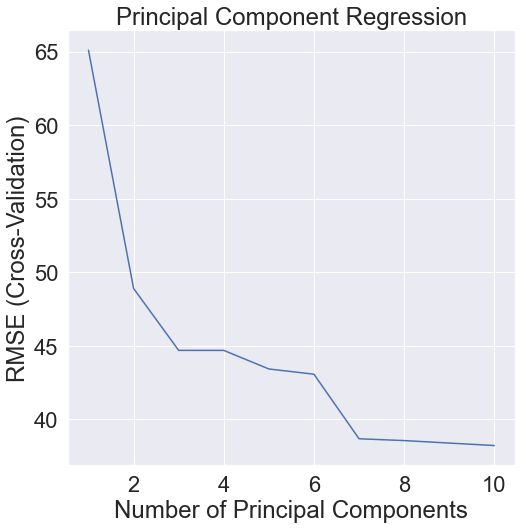

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
RMSE_set = -1*grid_search.cv_results_['mean_test_neg_root_mean_squared_error']

components_set = grid_search.cv_results_['param_pipeline__pca__n_components']

# Sketch Scree plot

fig = plt.figure(figsize = (8,8))
plot = sns.lineplot(x = components_set, y = RMSE_set)
plot.set(xlabel = "Number of Principal Components",
         ylabel = "RMSE (Cross-Validation)",
         title ="Principal Component Regression" )


#### Figure 8: Cross-validation score for increasing number of principal components in Regression.
Seeking a simple, reduced feature model using Principal Component Regression, it can be seen that not much gain in model performance is achieved beyond including 7 components in the regression.

In [ ]:
#Choosing 5 PC.
pclr_final2 = pipeline_pclr.set_params(**{'pipeline__pca__n_components' : 7})
#Fit the final model
pclr_final2.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['year',
                                                                    'month',
                                                                    'day',
                                                                    'PM10',
                                                                    'RAIN',
                                                                    'station',
                                                                    'wd']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['weekend'])])),
                                 ('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=7))])),
                ('linearregression', LinearRegression())])

### Model Evaluation
The final model is evaluated using the test data set. The performance metrics are observed and compared.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# predict on the test data set
y_pcr_pred = pclr_final2.predict(X_test)

# Calculate Mean Squared error
MSE_test = round(mean_squared_error(y_test, y_pcr_pred),2)
# Calculate Root Mean Squared Error
RMSE_test = round(np.sqrt(mean_squared_error(y_test, y_pcr_pred)),2)
# Calculate r2 score
r2_test = round(r2_score(y_test, y_pcr_pred),2)


results_df.join(pd.DataFrame([RMSE_test,MSE_test,r2_test],
                             columns = [" 5 PC model performance on test data"], 
                             index = ["RMSE","MSE",'r2'])) 

,Dummy Regressor,Untuned PCA Regressor,Tuned PCA regression,5 PC model performance on test data
RMSE,70.09 ± 0.27,38.23 ± 0.17,38.23 ± 0.16,38.95
MSE,4912.69 ± 38.49,1461.52 ± 12.85,1461.52 ± 12.84,1516.79
r2,-0.00 ± 0.00,0.70 ± 0.00,0.7 ± 0.0,0.70


### Plot of Predicted against True values and Learning Curve Plot
This is a visualisation of cross-validation training and test scores for different set sizes, applied to the whole data set. The visualisation shows the effect of adding more samples during the training process.

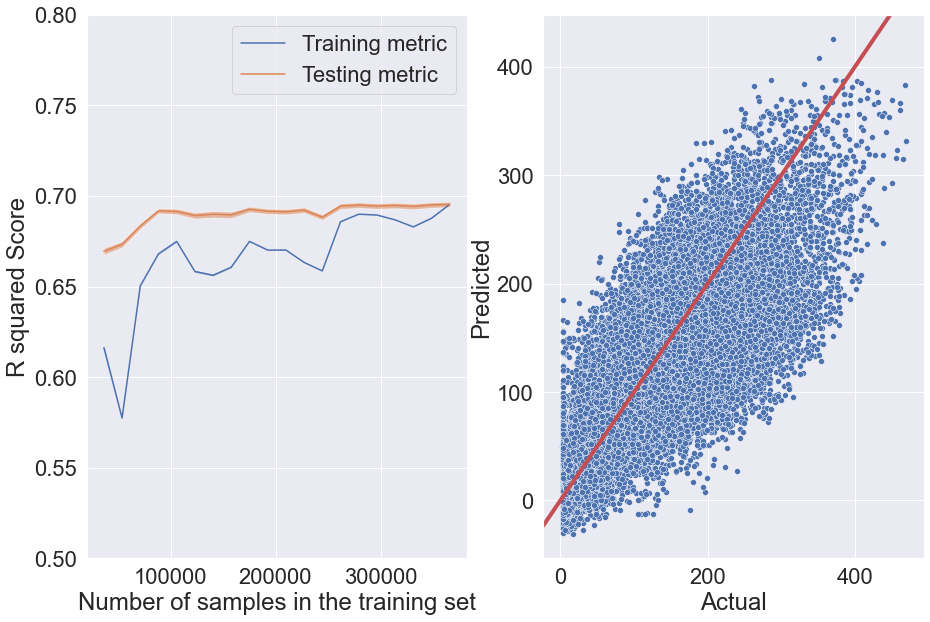

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay

fig,axs = plt.subplots(1,2, figsize = (15,10))

# Produce a Learning Curve Identifying training and test scores
train_sizes, train_scores, test_scores = learning_curve(pclr_final2, X, y,
                                                        train_sizes = np.linspace(0.1,1,20),
                                                        #scoring = 'neg_root_mean_squared_error',
                                                        n_jobs=-1,
                                                        random_state = 20,
                                                        cv = splitter)

display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores, 
                               test_scores=test_scores, 
                               score_name="R squared Score")

display.plot(ax = axs[0],
            score_type='both',
            std_display_style='fill_between')

axs[0].set_ylim(0.5,.8)

pred_data = pd.DataFrame(np.c_[y_test, y_pcr_pred], columns = ['Actual','Predicted'])
sns.scatterplot(data =pred_data,
                x = 'Actual',
                y = 'Predicted',
               ax = axs[1])

axs[1].axline((0, 0), slope=1,linewidth=4, color='r')


#### Figure 9: Learning Curve and Predicted vs Actual Plot
The variability in the training score for increasing sample size suggests that the linear model is limited in capturing the complexity of the data set. The testing score has plateaued and so the model won't benefit from increased training.